## Installs and imports

In [14]:
from pyscf import gto, scf, ao2mo
import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.drivers import PySCFDriver
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit_aer import Aer
from qiskit_algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import Estimator
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_algorithms.optimizers import SPSA
from qiskit_nature.second_q.algorithms import QEOM, GroundStateSolver
from IPython.display import Image
from qiskit_algorithms import VQE
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import BaseProblem

In [15]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Finding ground state of a system

In [16]:
def expand_to_spin_orbital_basis(h1_ao, eri_ao):
    n = h1_ao.shape[0]
    h1_spin = np.kron(h1_ao, np.eye(2))
    eri_spin = np.zeros((2*n, 2*n, 2*n, 2*n))
    for p in range(2*n):
        for q in range(2*n):
            for r in range(2*n):
                for s in range(2*n):
                    eri_spin[p, q, r, s] = eri_ao[p//2, q//2, r//2, s//2] * (
                        (p % 2 == r % 2) and (q % 2 == s % 2)
                    )
    return h1_spin, eri_spin

In [17]:
def get_fermionic_op(atom_string: str, spin: int, charge: int, basis: str = "sto-3g"):
    driver = PySCFDriver(
        atom=atom_string,
        basis=basis,
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()

    # Convert to FermionicOp
    atom_hamiltonian = problem.second_q_ops()

    return atom_hamiltonian[0]

In [18]:
def simulate_fermionic_op(atom_hamiltonian: FermionicOp, ansatz_reps: int = 2):
    # Convert to qubit Hamiltonian using Jordan-Wigner transformation
    mapper   = JordanWignerMapper()
    qubit_op = mapper.map(atom_hamiltonian)
    
    # Define the quantum ansatz
    ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=ansatz_reps)
    
    backend   = Aer.get_backend('statevector_simulator')
    estimator = Estimator()
    optimizer = SPSA()  # Create an instance of the optimizer
    vqe       = VQE(estimator, ansatz, optimizer)  # Pass the optimizer to VQE
    result    = vqe.compute_minimum_eigenvalue(qubit_op)
    optimized_ansatz = ansatz.assign_parameters(result.optimal_point)
    
    return result.eigenvalue.real, optimized_ansatz

In [20]:
# StringLi2S = "Li 0.25 0.25 0.25; Li 0.75 0.75 0.75; S 0 0 0"

StringLiH = "Li 0 0 0; H 0.5 0.5 0.5"
StringH2  = "H 0 0 0; H 0 0 0.735"

mol_op = get_fermionic_op(
    atom_string = StringH2,
    spin        = 0,
    charge      = 0
)

print("Built operator, running VQE...")

mol_ground_state, mol_optimal_ansatz = simulate_fermionic_op(mol_op, 4)

print("Hartree groundstate energy: ", mol_ground_state)

Built operator, running VQE...
Hartree groundstate energy:  -1.8423196467887353


In [21]:
mol_optimal_ansatz.decompose().draw()

┌─────────────┐            ┌────────────┐                                 »
q_0: ┤ Ry(-4.9349) ├─■──■─────■─┤ Ry(5.5291) ├──────────────────────■────────■─»
     └┬────────────┤ │  │     │ └────────────┘┌─────────────┐       │        │ »
q_1: ─┤ Ry(3.7821) ├─■──┼──■──┼───────■───────┤ Ry(-5.8753) ├───────■────────┼─»
      ├───────────┬┘    │  │  │       │       └─────────────┘┌─────────────┐ │ »
q_2: ─┤ Ry(0.261) ├─────■──■──┼───────┼──────────────■───────┤ Ry(-4.4445) ├─■─»
      ├───────────┤           │       │              │       └┬────────────┤   »
q_3: ─┤ Ry(4.895) ├───────────■───────■──────────────■────────┤ Ry(7.8434) ├───»
      └───────────┘                                           └────────────┘   »
«           ┌────────────┐                                         »
«q_0: ────■─┤ Ry(3.1722) ├────────────────────────■────────■─────■─»
«         │ └────────────┘┌────────────────┐      │        │     │ »
«q_1: ─■──┼───────■───────┤ Ry(-0.0081019) ├──────■────────┼──■──┼─»
«      │  │       │       └────────────────┘┌────────────┐ │  │  │ »
«q_2: ─■──┼───────┼───────────────■─────────┤ Ry(3.5479) ├─■──■──┼─»
«         │       │               │         ├────────────┤       │ »
«q_3: ────■───────■───────────────■─────────┤ Ry(9.2659) ├───────■─»
«                                           └────────────┘         »
«     ┌────────────┐                                      ┌───────────┐»
«q_0: ┤ Ry(7.4794) ├─────────────────────■────────■─────■─┤ Ry(1.266) ├»
«     └────────────┘┌────────────┐       │        │     │ └───────────┘»
«q_1: ──────■───────┤ Ry(9.6744) ├───────■────────┼──■──┼───────■──────»
«           │       └────────────┘┌─────────────┐ │  │  │       │      »
«q_2: ──────┼─────────────■───────┤ Ry(-2.1632) ├─■──■──┼───────┼──────»
«           │             │       └┬────────────┤       │       │      »
«q_3: ──────■─────────────■────────┤ Ry(5.0135) ├───────■───────■──────»
«                                  └────────────┘                      »
«                                    
«q_0: ───────────────────────────────
«     ┌──────────────┐               
«q_1: ┤ Ry(-0.73447) ├───────────────
«     └──────────────┘ ┌────────────┐
«q_2: ───────■─────────┤ Ry(-6.306) ├
«            │        ┌┴────────────┤
«q_3: ───────■────────┤ Ry(-4.4628) ├
«                     └─────────────┘

## Finding higher energy eigenstates

Relevant reference: https://arxiv.org/abs/1910.12890

In [22]:
from qiskit_nature.second_q.problems import ElectronicStructureProblem

def get_higher_energy_states(atom_string: str, spin: int, charge: int, basis: str = "sto-3g", ansatz_reps: int = 2):
    backend   = Aer.get_backend('statevector_simulator')
    estimator = Estimator()
    mapper    = JordanWignerMapper()

    driver = PySCFDriver(
        atom=atom_string,
        basis=basis,
        charge=charge,
        spin=spin,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()

    optimizer  = SPSA()
    ansatz     = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', reps=ansatz_reps)
    vqe_solver = VQE(estimator, ansatz, optimizer)
    
    ground_state_solver = GroundStateEigensolver(mapper, vqe_solver)
    
    qeom_solver = QEOM(
        ground_state_solver=ground_state_solver,
        estimator=estimator,
        excitations="sd"
    )
    qeom_result = qeom_solver.solve(problem)

    return qeom_result.groundenergy, qeom_result.total_energies

In [101]:
h2_ground_energy, h2_higher_energies = get_higher_energy_states(
    atom_string = StringH2,
    spin        = 0,
    charge      = 0,
    ansatz_reps = 7
)
print("H2:   ", h2_ground_energy, h2_higher_energies)

h2c1_ground_energy, h2c1_higher_energies = get_higher_energy_states(
    atom_string = StringH2,
    spin        = 1,
    charge      = 1,
    ansatz_reps = 7
)
print("H2+1: ", h2c1_ground_energy, h2c1_higher_energies)

# lih_ground_energy, lih_higher_energies = get_higher_energy_states(
#     atom_string = StringLiH,
#     spin        = 0,
#     charge      = 0,
#     ansatz_reps = 2
# )
# print("LiH: ", lih_ground_energy, lih_higher_energies)

H2:    -1.8015315058713384 [-1.08156251 -0.45938082 -0.10087952  0.57079161]
H2+1:  -1.778100669953277 [-1.05813168 -0.24346688]


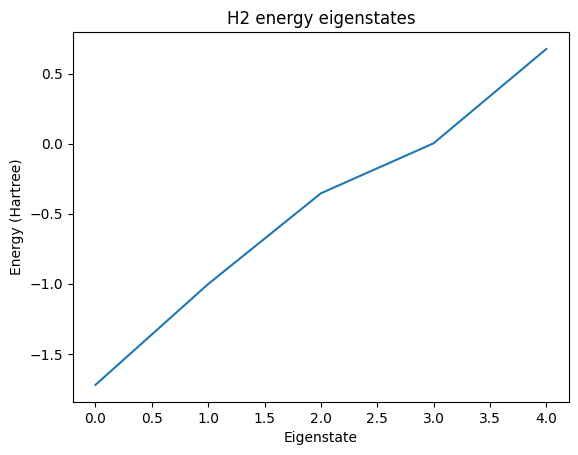

In [30]:
h2_energies = [h2_ground_energy] + list(h2_higher_energies)
plt.plot(h2_energies)
plt.title("H2 energy eigenstates")
plt.ylabel("Energy (Hartree)")
plt.xlabel("Eigenstate")
plt.show()

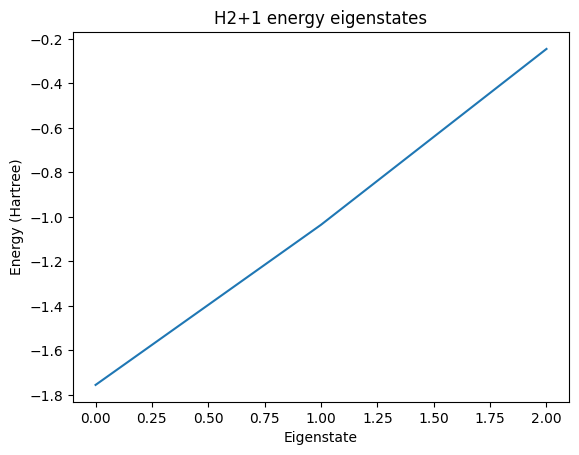

In [31]:
h2c1_energies = [h2c1_ground_energy] + list(h2c1_higher_energies)
plt.plot(h2c1_energies)
plt.title("H2+1 energy eigenstates")
plt.ylabel("Energy (Hartree)")
plt.xlabel("Eigenstate")
plt.show()

## Compute variables of interest

In [72]:
import numpy as np

temperature = 300 # in Kelvin
beta        = 1 / (0.08617333262 * temperature) # meV

h2_delta_energies = [E - h2_ground_energy for E in h2_energies]

# Partition function
# Z = sum(np.exp(-beta * e * 27211.4) for e in delta_energies) # Hartree to meV
Z = sum(np.exp(-beta * e) for e in h2_delta_energies) # not converting to make sure we have something to look at

# Free energy
F = -1/beta * np.log(Z)

print(f"Approximate Free Energy at 300K: {F:.6f}")

Approximate Free Energy at 300K: -40.378318


In [124]:
def partition_function(energies, temperature):
    # Z = sum(np.exp(-beta * e * 27211.4) for e in energies) # Hartree to meV
    Z = sum(np.exp(-beta * e) for e in energies) # not converting to make sure we have something to look at
    return Z

In [125]:
def free_energy(Z, temperature):
    beta = 1 / (0.08617333262 * temperature) # meV
    F    = -1 / beta * np.log(Z)

    return F

In [126]:
def heat_capacity(energies, partition_function, temperature):
    energies = np.array(energies)
    
    beta              = 1 / (0.08617333262 * temperature) # meV
    boltzmann_factors = np.exp(-beta * energies)
    probabilities     = boltzmann_factors / partition_function

    U  = np.sum(probabilities * energies)
    U2 = np.sum(probabilities * energies**2)

    Cv = beta**2 * (U2 - U**2)

    return Cv

In [57]:
temperatures    = np.linspace(10, 500, num=500)
free_energies   = []
heat_capacities = []

for temp in temperatures:
    Z = partition_function(h2_delta_energies, temp)
    free_energies.append(free_energy(Z, temp))
    heat_capacities.append(heat_capacity(h2_delta_energies, Z, temp)) 

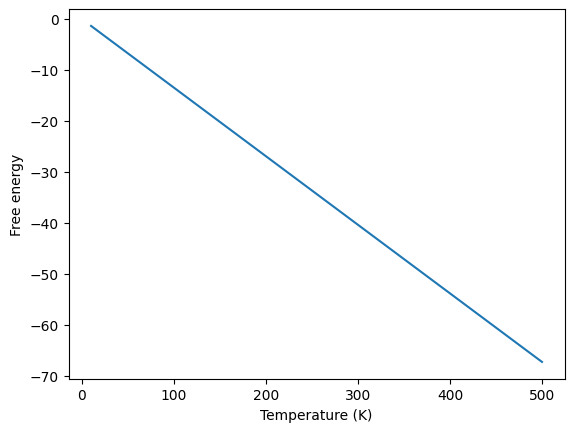

In [58]:
plt.plot(temperatures, free_energies)
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy")
plt.show()

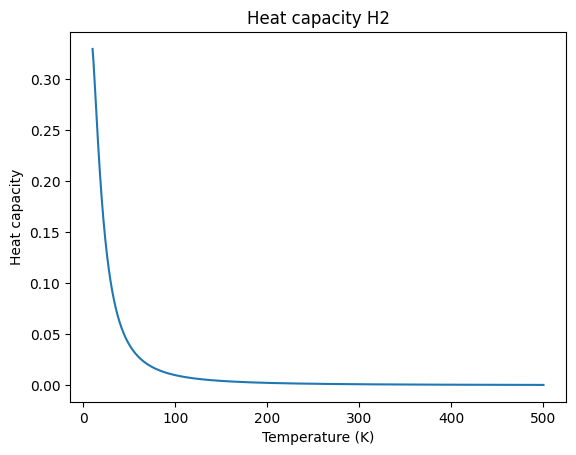

In [59]:
plt.plot(temperatures, heat_capacities)
plt.title("Heat capacity H2")
plt.xlabel("Temperature (K)")
plt.ylabel("Heat capacity")
plt.show()

In [127]:
T_values = np.linspace(10, 5000, 100)  # 10 K to 5000 K

# Compute ionization energy vs T
IE_vs_T = []

for T in T_values:
    Z_neutral = partition_function(h2_energies, T)
    F_neutral = free_energy(Z_neutral, T)

    Z_cation = partition_function(h2c1_energies, T)
    F_cation = free_energy(Z_cation, T)
    
    IE = F_cation - F_neutral
    IE_vs_T.append(IE)

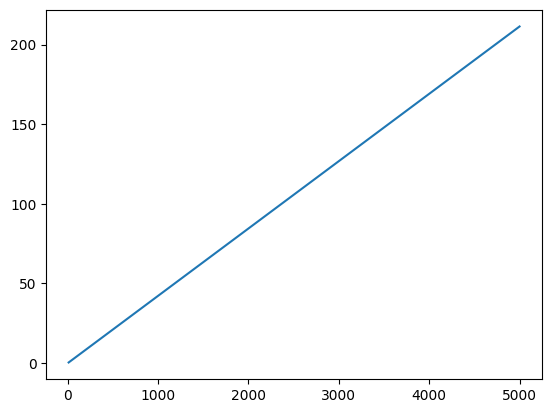

In [129]:
plt.plot(T_values, IE_vs_T)
plt.axis()
plt.show()

In [130]:
def get_temp_distance(distance, temperatures):
    StringH2  = "H 0 0 0; H 0 0 " + str(distance)
    print("  Molecule: ", StringH2)

    h2_ground_energy, h2_higher_energies = get_higher_energy_states(
        atom_string = StringH2,
        spin        = 0,
        charge      = 0,
        ansatz_reps = 7
    )
    h2_energies = [h2_ground_energy] + h2_higher_energies
    
    h2c1_ground_energy, h2c1_higher_energies = get_higher_energy_states(
        atom_string = StringH2,
        spin        = 1,
        charge      = 1,
        ansatz_reps = 7
    )
    h2c1_energies = [h2c1_ground_energy] + h2c1_higher_energies
    
    print("  H2 ground energy: ", h2_ground_energy, ", excited energies: ", h2_higher_energies)
    print("  H2+1 ground energy: ", h2c1_ground_energy, ", excited energies: ", h2c1_higher_energies)
    print("  Ionization energy: ", h2c1_ground_energy - h2_ground_energy)

    # Compute ionization energy vs T
    IE_vs_T = []
    
    for T in temperatures:
        Z_neutral = partition_function(h2_energies, T)
        F_neutral = free_energy(Z_neutral, T)
    
        Z_cation = partition_function(h2c1_energies, T)
        F_cation = free_energy(Z_cation, T)
        
        IE = F_cation - F_neutral
        IE_vs_T.append(IE)

    return IE_vs_T

In [131]:
distances          = np.linspace(0.5, 1.5, 40)
temperatures       = np.linspace(10, 5000, 100)
energy_differences = []
ionization_energy  = []

for distance in distances:
    print("Looking at intramolecular distance: ", distance)
    temp_distance = get_temp_distance(distance, temperatures)
    energy_differences.append(temp_distance)
    ionization_energy.append(temp_distance[0])
    print()

Looking at intramolecular distance:  0.5
  Molecule:  H 0 0 0; H 0 0 0.5
  H2 ground energy:  -1.826034062708347 , excited energies:  [-0.76767964  0.20569617  0.51218976  1.56986763]
  H2+1 ground energy:  -2.034910277206718 , excited energies:  [-0.97655586  0.16439416]
  Ionization energy:  -0.20887621449837113

Looking at intramolecular distance:  0.5256410256410257
  Molecule:  H 0 0 0; H 0 0 0.5256410256410257
  H2 ground energy:  -1.9203937751675078 , excited energies:  [-0.9136664  -0.01302016  0.31626704  1.32061185]
  H2+1 ground energy:  -2.0367612726040503 , excited energies:  [-1.0300339   0.10983868]
  Ionization energy:  -0.11636749743654251

Looking at intramolecular distance:  0.5512820512820513
  Molecule:  H 0 0 0; H 0 0 0.5512820512820513
  H2 ground energy:  -1.817592121377771 , excited energies:  [-0.85768927  0.02000286  0.34848961  1.30447815]
  H2+1 ground energy:  -1.8489470460485904 , excited energies:  [-0.8890442  0.2437844]
  Ionization energy:  -0.0313549

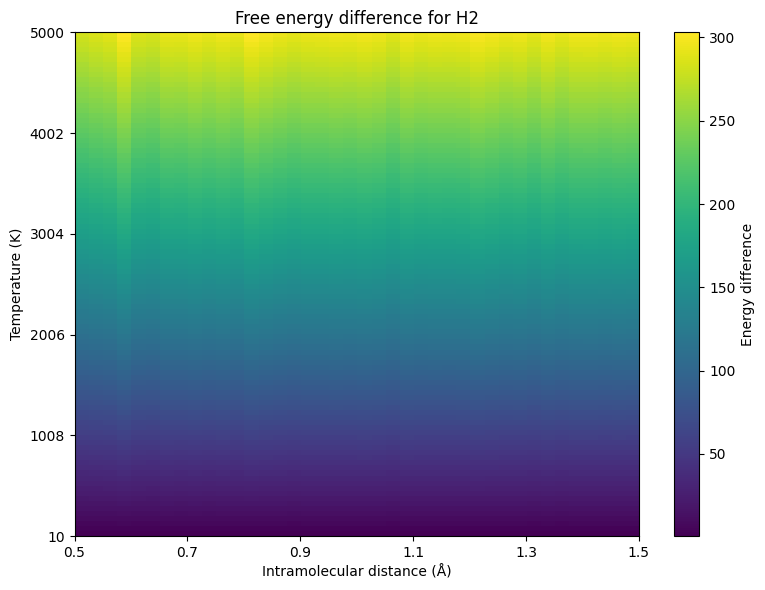

In [134]:
energy_differences = np.array(energy_differences)

plt.figure(figsize=(8, 6))
plt.imshow(
    energy_differences.T,  # Transpose so that x = distance, y = temperature
    extent=[distances.min(), distances.max(), temperatures.min(), temperatures.max()],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

plt.colorbar(label="Energy difference")
plt.xlabel("Intramolecular distance (Å)")
plt.ylabel("Temperature (K)")

plt.xticks(np.linspace(distances.min(), distances.max(), 6))
plt.yticks(np.linspace(temperatures.min(), temperatures.max(), 6))

# Title
plt.title("Free energy difference for H2")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'H2 ionization energy')

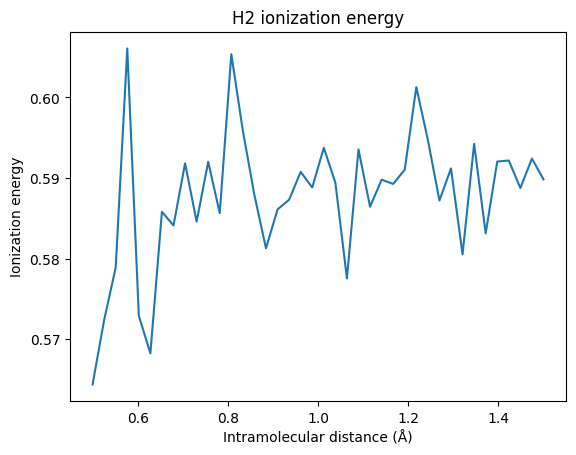

In [133]:
plt.plot(distances, ionization_energy)
plt.xlabel("Intramolecular distance (Å)")
plt.ylabel("Ionization energy")
plt.title("H2 ionization energy")